## Common Sense Reasoning - NLP Assignment 

**Objective:** 

To build a system that can outperform a baseline model with an accuracy of 0.2 using fastText, word2vec, and GloVe word embeddings. Additionally, compare the performance of these pretrained embedding models in terms of accuracy.


In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import gensim.downloader
import random

### 1- Load from the JSON file

In [103]:
data = []
with open('train_rand_split.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

        
data[:2] 

[{'answerKey': 'A',
  'id': '075e483d21c29a511267ef62bedc0461',
  'question': {'question_concept': 'punishing',
   'choices': [{'label': 'A', 'text': 'ignore'},
    {'label': 'B', 'text': 'enforce'},
    {'label': 'C', 'text': 'authoritarian'},
    {'label': 'D', 'text': 'yell at'},
    {'label': 'E', 'text': 'avoid'}],
   'stem': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'}},
 {'answerKey': 'B',
  'id': '61fe6e879ff18686d7552425a36344c8',
  'question': {'question_concept': 'people',
   'choices': [{'label': 'A', 'text': 'race track'},
    {'label': 'B', 'text': 'populated areas'},
    {'label': 'C', 'text': 'the desert'},
    {'label': 'D', 'text': 'apartment'},
    {'label': 'E', 'text': 'roadblock'}],
   'stem': 'Sammy wanted to go to where the people were.  Where might he go?'}}]

In [104]:
questions = []
answer_keys = []
all_answers = []

for entry in data:
    question = entry['question']['stem']
    answer_key = entry['answerKey']
    choices = entry['question']['choices']
    all_choices = [choice['text'] for choice in choices]
    
    # Concatenate all the answers into a single string
    all_answers.append(", ".join(all_choices))
    
    # Append the question and answer key to their respective lists
    questions.append(question)
    answer_keys.append(answer_key)

df = pd.DataFrame({'question': questions, 'answerKey': answer_keys, 'all_answers': all_answers})


df.head()


,question,answerKey,all_answers
0,The sanctions against the school were a punish...,A,"ignore, enforce, authoritarian, yell at, avoid"
1,Sammy wanted to go to where the people were. ...,B,"race track, populated areas, the desert, apart..."
2,To locate a choker not located in a jewelry bo...,A,"jewelry store, neck, jewlery box, jewelry box,..."
3,Google Maps and other highway and street GPS s...,D,"united states, mexico, countryside, atlas, oceans"
4,"The fox walked from the city into the forest, ...",C,"pretty flowers., hen house, natural habitat, s..."


### 2- Pre-process the text data

In [105]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


In [106]:
df['question'] = df['question'].apply(preprocess_text)
df.head()

,question,answerKey,all_answers
0,sanction school punishing blow seemed effort s...,A,"ignore, enforce, authoritarian, yell at, avoid"
1,sammy wanted go people might go,B,"race track, populated areas, the desert, apart..."
2,locate choker located jewelry box boutique wou...,A,"jewelry store, neck, jewlery box, jewelry box,..."
3,google map highway street gps service replaced,D,"united states, mexico, countryside, atlas, oceans"
4,fox walked city forest looking,C,"pretty flowers., hen house, natural habitat, s..."


### 3- Random baseline model

In [107]:
def calculate_accuracy_random(data):
    correct_predictions = 0
    total_questions = len(data)

    for question in data:
        answer_key = question["answerKey"]
        prediction_label = random.choice(question["question"]["choices"])["label"]

        if prediction_label == answer_key:
            correct_predictions += 1

    accuracy = correct_predictions / total_questions
    return accuracy

# Calculate accuracy for random baseline model
accuracy_random_baseline = calculate_accuracy_random(data)

print(f"Accuracy for random baseline model: {accuracy_random_baseline}")

Accuracy for random baseline model: 0.19802894979981522


In [108]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['question'], df['answerKey'] , test_size=0.2, random_state=42)

### 3- Load pre-trained word embeddings


In [36]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
glove_model = gensim.downloader.load('glove-wiki-gigaword-300')
fasttext_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

### 4- Convert the text data into vector representations

In [109]:
# Function to convert text to embeddings using a given model
def text_to_embedding(text, model):
    words = text# Tokenize the text
    word_embeddings = [model[word] for word in words if word in model]  # Get embeddings for words in vocabulary
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)  # Average the word embeddings
    else:
        return np.zeros(model.vector_size)  # Use zero vector if no embeddings found


### Train models

In [110]:
def calculate_embeddings(text_data, all_answers, model):
    question_embeddings = []
    answer_embeddings = []

    # Calculate question embeddings
    for question in text_data:
        words = question.split()  # Tokenize the question
        word_embeddings = [model[word] for word in words if word in model]  # Get embeddings for words in vocabulary
        if word_embeddings:
            question_embeddings.append(np.mean(word_embeddings, axis=0))  # Average the word embeddings
        else:
            question_embeddings.append(np.zeros(model.vector_size))  # Use zero vector if no embeddings found

    # Calculate answer embeddings
    for answers in all_answers:
        answer_embedding = {}
        for i, answer in enumerate(answers.split(',')):
            words = answer.strip().split()  # Tokenize the answer
            word_embeddings = [model[word] for word in words if word in model]  # Get embeddings for words in vocabulary
            if word_embeddings:
                answer_embedding[chr(ord('A') + i)] = np.mean(word_embeddings, axis=0)  # Average the word embeddings
            else:
                answer_embedding[chr(ord('A') + i)] = np.zeros(model.vector_size)  # Use zero vector if no embeddings found
        answer_embeddings.append(answer_embedding)

    return question_embeddings, answer_embeddings


In [111]:
# Function to calculate cosine similarity between two vectors
def calculate_cosine_similarity(vector1, vector2):
    return cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]


In [112]:
def predict_answer(question_embedding, answer_embeddings):
    max_cosine_similarity = -1
    predicted_answer = None
    
    # Iterate through each answer choice and calculate cosine similarity
    for answer_choice, answer_embedding in answer_embeddings.items():
        cosine_similarity = calculate_cosine_similarity(question_embedding, answer_embedding)
        if cosine_similarity > max_cosine_similarity:
            max_cosine_similarity = cosine_similarity
            predicted_answer = answer_choice
    
    return predicted_answer


In [113]:
# Calculate embeddings for each model
question_embeddings_fasttext, answer_embeddings_fasttext = calculate_embeddings(X_train, df.loc[X_train.index, 'all_answers'], fasttext_model)
question_embeddings_word2vec, answer_embeddings_word2vec = calculate_embeddings(X_train, df.loc[X_train.index, 'all_answers'], word2vec_model)
question_embeddings_glove, answer_embeddings_glove = calculate_embeddings(X_train, df.loc[X_train.index, 'all_answers'], glove_model)

In [114]:

# Predict answers using cosine similarity for each model
predictions_fasttext = [predict_answer(question_embedding, answer_embedding) for question_embedding, answer_embedding in zip(question_embeddings_fasttext, answer_embeddings_fasttext)]
predictions_word2vec = [predict_answer(question_embedding, answer_embedding) for question_embedding, answer_embedding in zip(question_embeddings_word2vec, answer_embeddings_word2vec)]
predictions_glove = [predict_answer(question_embedding, answer_embedding) for question_embedding, answer_embedding in zip(question_embeddings_glove, answer_embeddings_glove)]

### 6- Evaluate the performance of the models

In [115]:
aligned_predictions_fasttext = predictions_fasttext[:len(y_test)]
aligned_predictions_word2vec = predictions_word2vec[:len(y_test)]
aligned_predictions_glove = predictions_glove[:len(y_test)]

In [116]:
# Compute the accuracy score for each model
accuracy_fasttext = accuracy_score(y_test, aligned_predictions_fasttext)
accuracy_word2vec = accuracy_score(y_test, aligned_predictions_word2vec)
accuracy_glove = accuracy_score(y_test, aligned_predictions_glove)

In [117]:
print("Accuracy using FastText:", accuracy_fasttext)
print("Accuracy using Word2Vec:", accuracy_word2vec)
print("Accuracy using GloVe:", accuracy_glove)

Accuracy using FastText: 0.1831708568496665
Accuracy using Word2Vec: 0.19035402770651616
Accuracy using GloVe: 0.19035402770651616


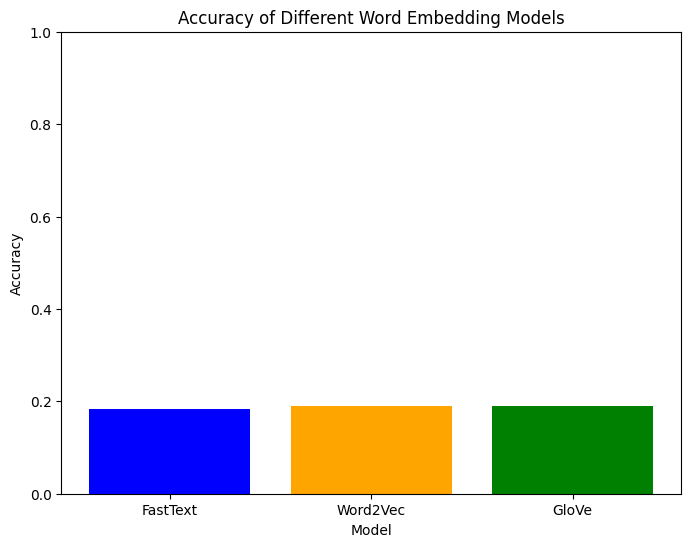

In [118]:
import matplotlib.pyplot as plt

# Define the models and their accuracies
models = ['FastText', 'Word2Vec', 'GloVe']
accuracies = [accuracy_fasttext, accuracy_word2vec, accuracy_glove]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Word Embedding Models')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy percentage

# Display the plot
plt.show()
